In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


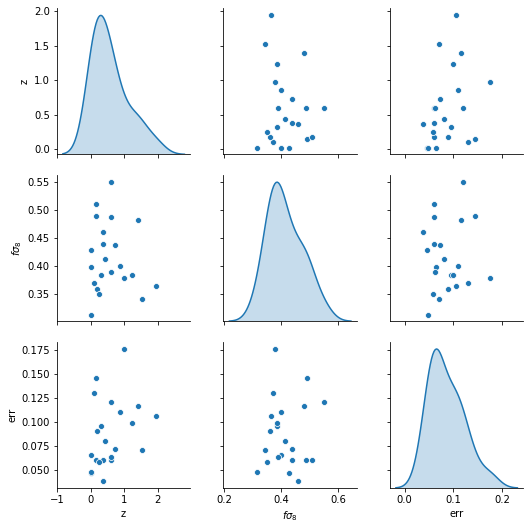

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)
np.max(z)

1.944

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 100

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0606 - val_loss: 0.0293
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0232 - val_loss: 0.0171
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0170 - val_loss: 0.0127
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0140
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 11/

Epoch 83/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 84/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 85/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 86/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 87/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 88/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 89/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 90/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 91/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 92/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0021


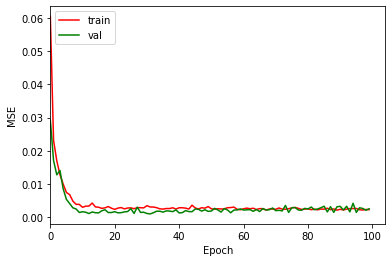

In [13]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)


In [14]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
# print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e

0.00205179862678051 0.0009175256127491593


In [15]:
pred = neural_model.predict(z_test)
pred

array([[0.45352012, 0.06394037],
       [0.46392703, 0.10059175],
       [0.457134  , 0.11197838],
       [0.4475367 , 0.11615928],
       [0.43069017, 0.11218353]], dtype=float32)

In [16]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [17]:
ranz = np.random.uniform(0, 2, size=1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


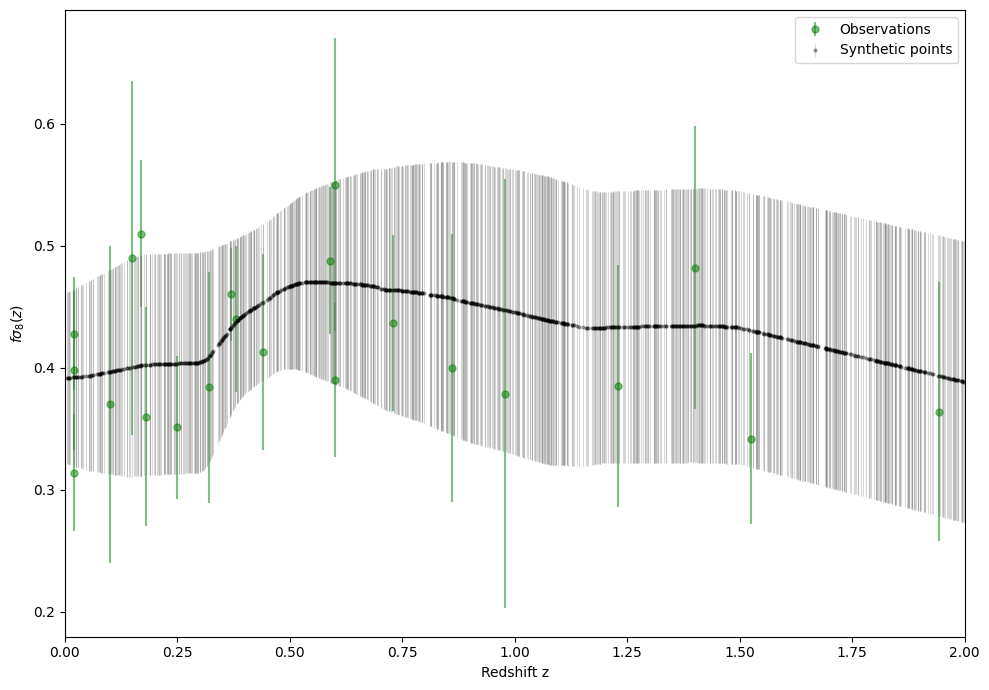

In [18]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',)
plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend(loc='upper right')
# plt.legend()
# plt.savefig("synthetic_fs8_20.png")

In [20]:
from functools import partial
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8
w0 = -1

In [31]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

  
def growth_lcdm(z):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# returns the growth factor as a function of redshift
def GrowthIntegrand_a_lcdm(a):
    rhsquareda = RHSquared_a_lcdm(a) 
    return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)


def fs8lcdm(z):
    return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)


# def Hlcdm(a, H0=73.24):
#     z = 1./a-1
#     return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [43]:
z = np.linspace(0.0, 2, 100)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []

# flcdm = []
for zz in z:
    flcdm.append(fs8lcdm(zz))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)


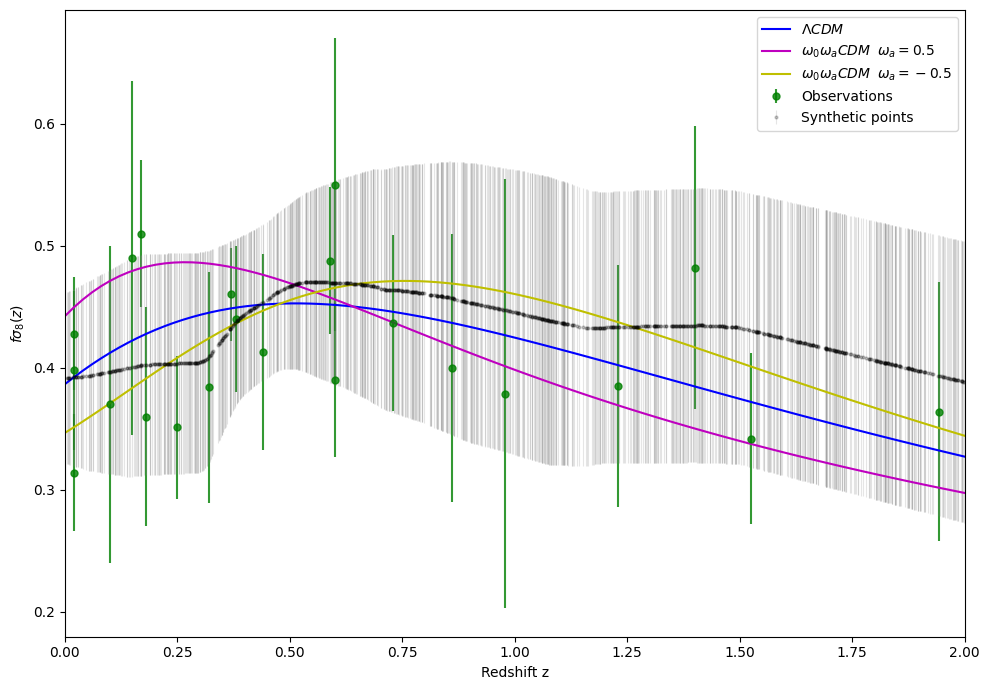

In [47]:
z = np.linspace(0, 2, 100)
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.2, c='k',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')

plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=800)

In [ ]:
# pred_random.shape, r.shape

In [48]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [49]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [50]:
mookHz

array([[0.39543119, 0.44275868, 0.06588664],
       [1.35905709, 0.43447506, 0.11205505],
       [1.47167501, 0.43378407, 0.11222136],
       [1.26328927, 0.43383253, 0.11154479],
       [0.96634368, 0.44844133, 0.11584193],
       [1.78645495, 0.40748855, 0.11393382],
       [0.56604875, 0.47005847, 0.078292  ],
       [1.51577609, 0.43160093, 0.11211483],
       [1.35927068, 0.43447649, 0.11205618],
       [0.71368105, 0.46421406, 0.09868219],
       [1.29612783, 0.43405288, 0.11171976],
       [1.91197752, 0.39630696, 0.11477734],
       [1.94520329, 0.39334714, 0.11500064],
       [1.85566134, 0.40132362, 0.1143989 ],
       [1.71597162, 0.41376734, 0.11346018],
       [1.12785623, 0.43507409, 0.11531579],
       [0.82116844, 0.45955101, 0.10853063],
       [0.22332554, 0.40322399, 0.09046234],
       [1.63501682, 0.42097884, 0.11291616],
       [0.20006831, 0.40288305, 0.0904873 ],
       [1.98316971, 0.389965  , 0.11525576],
       [0.354895  , 0.42550689, 0.0759718 ],
       [1.

In [51]:
predy_reduced[:,1]

array([0.06588664, 0.11205505, 0.11222136, 0.11154479, 0.11584193,
       0.11393382, 0.078292  , 0.11211483, 0.11205618, 0.09868219,
       0.11171976, 0.11477734, 0.11500064, 0.1143989 , 0.11346018,
       0.11531579, 0.10853063, 0.09046234, 0.11291616, 0.0904873 ,
       0.11525576, 0.0759718 , 0.1124056 , 0.11349419, 0.11549015,
       0.09037421, 0.06430621, 0.09863727, 0.11438495, 0.11795141,
       0.10339968, 0.11361226, 0.11358964, 0.11477786, 0.10885692,
       0.08477986, 0.11260606, 0.11769341, 0.07755671, 0.11235614,
       0.11227317, 0.11519228, 0.06932287, 0.08522181, 0.11411013,
       0.06599428, 0.11453137, 0.06915148, 0.11350204, 0.09041522],
      dtype=float32)

In [52]:
error  = predy_reduced[:,1]**2
error

array([0.00434105, 0.01255633, 0.01259363, 0.01244224, 0.01341935,
       0.01298091, 0.00612964, 0.01256974, 0.01255659, 0.00973818,
       0.0124813 , 0.01317384, 0.01322515, 0.01308711, 0.01287321,
       0.01329773, 0.0117789 , 0.00818344, 0.01275006, 0.00818795,
       0.01328389, 0.00577171, 0.01263502, 0.01288093, 0.01333798,
       0.0081675 , 0.00413529, 0.00972931, 0.01308392, 0.01391253,
       0.01069149, 0.01290775, 0.01290261, 0.01317396, 0.01184983,
       0.00718762, 0.01268013, 0.01385174, 0.00601504, 0.0126239 ,
       0.01260526, 0.01326926, 0.00480566, 0.00726276, 0.01302112,
       0.00435524, 0.01311743, 0.00478193, 0.01288271, 0.00817491],
      dtype=float32)

In [53]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

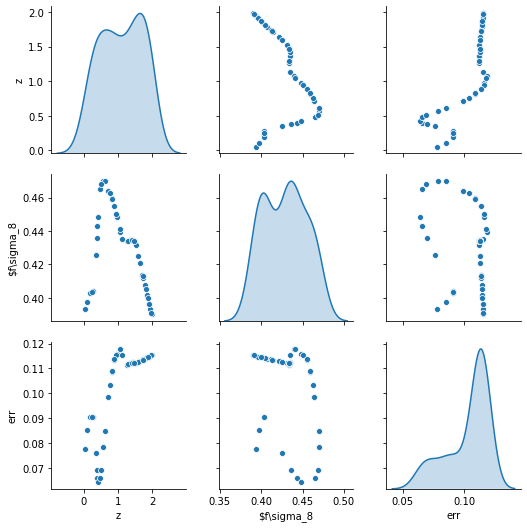

In [54]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [55]:
from astroNN.nn.layers import MCDropout

In [56]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((80,), (22, 1), (20,), (0, 1))

In [71]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 50, 50])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=3000,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/3000
5/5 [==============================] - 0s 18ms/step - loss: 0.1166 - val_loss: 0.1301
Epoch 2/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.1023 - val_loss: 0.1086
Epoch 3/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.1056 - val_loss: 0.0957
Epoch 4/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0829 - val_loss: 0.1037
Epoch 5/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0960 - val_loss: 0.1058
Epoch 6/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0883 - val_loss: 0.0888
Epoch 7/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0747 - val_loss: 0.0733
Epoch 8/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0729 - val_loss: 0.0814
Epoch 9/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0775 - val_loss: 0.0685
Epoch 10/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0659 - val_loss: 0.0694
Epoch 11/3000
5/5 

Epoch 84/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0051
Epoch 85/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 86/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0131
Epoch 87/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 88/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0070
Epoch 89/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0128
Epoch 90/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0144
Epoch 91/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0126
Epoch 92/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0165
Epoch 93/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0084
Epoch 94/3

5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 167/3000
5/5 [==============================] - ETA: 0s - loss: 0.012 - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 168/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0100
Epoch 169/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 170/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0033
Epoch 171/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0047
Epoch 172/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 173/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0018
Epoch 174/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 175/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss

Epoch 248/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 249/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 250/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0020
Epoch 251/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 252/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 253/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0042
Epoch 254/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 255/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 256/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0026
Epoch 257/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0033


Epoch 330/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 331/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 332/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 333/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 334/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 335/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 336/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 337/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 338/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 339/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0032


5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 412/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 413/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 414/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 415/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 416/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 417/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0046
Epoch 418/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 419/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 420/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0079
Epoch 421/3000


5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 494/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 495/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 496/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 497/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 498/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0014
Epoch 499/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 500/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0027
Epoch 501/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 502/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 503/3000


Epoch 575/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 576/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 577/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 578/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 579/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 580/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 581/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 582/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 583/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 584/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0022


Epoch 657/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 658/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 659/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 660/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 661/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 662/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 663/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 664/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 665/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 666/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0026


Epoch 739/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 740/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 741/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 742/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 743/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 744/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 745/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 746/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 747/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 748/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0037


Epoch 821/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 822/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 823/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 824/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 825/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 826/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 827/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 828/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 829/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 830/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0015


5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 903/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 904/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 905/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 906/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 907/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 908/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 909/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 910/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 911/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 912/3000


5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 985/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 986/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 987/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 988/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 989/3000
5/5 [==============================] - ETA: 0s - loss: 0.002 - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 990/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 991/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 992/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 993/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss

5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 1066/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 1067/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 1068/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 1069/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 1070/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 1071/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 1072/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1073/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 1074/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 1147/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 1148/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1149/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 1150/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 1151/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 1152/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 1153/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 1154/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 1155/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 1228/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 1229/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 1230/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 1231/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 1232/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 1233/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 1234/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 1235/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 1236/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 1309/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 1310/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 1311/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 1312/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 1313/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 1314/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 1315/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 1316/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1317/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 1390/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 1391/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 1392/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 1393/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 1394/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 1395/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 1396/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 1397/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 1398/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 1471/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 1472/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 1473/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 1474/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 1475/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 1476/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 1477/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 1478/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 1479/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 1552/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 1553/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 1554/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 1555/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 1556/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1557/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 1558/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 1559/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 1560/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 1633/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1634/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 1635/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 1636/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 1637/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 1638/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 1639/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 1640/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1641/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 1714/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 1715/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 1716/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 1717/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1718/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 1719/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 1720/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1721/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 1722/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 1795/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 1796/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 1797/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 1798/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 1799/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 1800/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 1801/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 1802/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 1803/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1876/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 1877/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 1878/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 1879/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 1880/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 1881/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 1882/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 1883/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 1884/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 

Epoch 1956/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 1957/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 1958/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 1959/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 1960/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 1961/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 1962/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 1963/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 1964/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 1965/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_los

Epoch 2037/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 2038/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 2039/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 2040/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 2041/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 2042/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 2043/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 2044/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 2045/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 2046/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_los

5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 2119/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 2120/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 2121/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 2122/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 2123/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 2124/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 2125/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 2126/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 2127/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 2200/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 2201/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 2202/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 2203/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 2204/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 2205/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 2206/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 2207/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 2208/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 

Epoch 2280/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 2281/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 2282/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2283/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 2284/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 2285/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 2286/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 2287/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 2288/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 2289/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_los

5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 2362/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 2363/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 2364/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 2365/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 8.8927e-04
Epoch 2366/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 2367/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 2368/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 2369/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 2370/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0021
Ep

Epoch 2442/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 2443/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 2444/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 2445/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 2446/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 2447/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 2448/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 2449/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 2450/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 2451/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_los

5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 2524/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 2525/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2526/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 2527/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 2528/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 2529/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 2530/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 2531/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 2532/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 2605/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 2606/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 2607/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 2608/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2609/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 2610/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 2611/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 2612/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 2613/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 2686/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 2687/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 2688/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 2689/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 2690/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 2691/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 9.8852e-04
Epoch 2692/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 2693/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 2694/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0037
Ep

5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 2767/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 2768/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2769/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 2770/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 2771/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 2772/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 2773/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 2774/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 2775/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2848/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 2849/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 2850/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 2851/3000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2852/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 2853/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 2854/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 2855/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 2856/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 

Epoch 2928/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 2929/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 2930/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 2931/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 2932/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 2933/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 2934/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 2935/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2936/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 2937/3000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_los

In [72]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [73]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.025521165428863127, 0.010820188875464109)

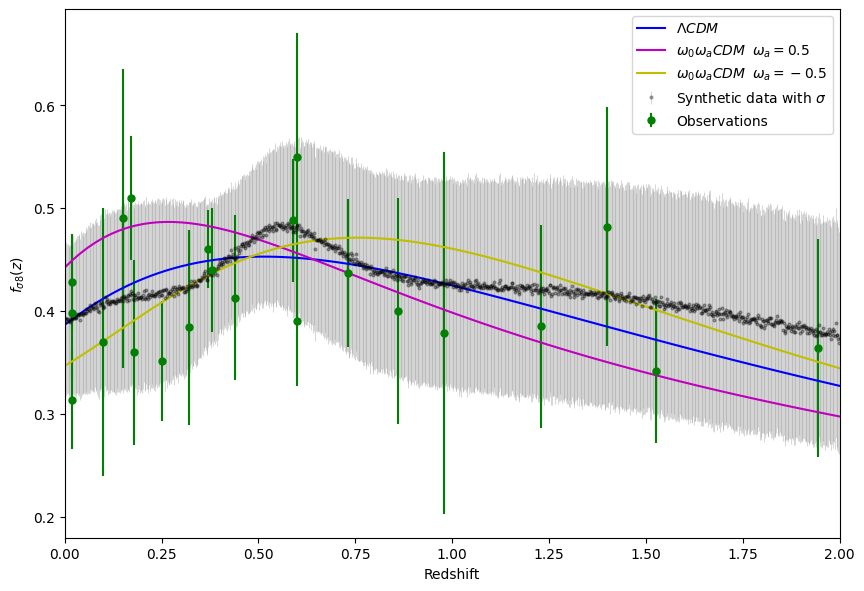

In [76]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0,2)
plt.xlabel('Redshift')
plt.ylabel('$f_{\sigma8}(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('fs8_dropout.png', dpi=200)

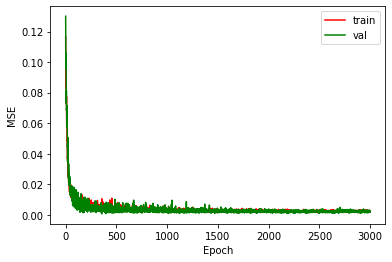

In [75]:
plt.plot(model2_train.history['loss'], color='r')
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig('lossfs8dropout.png', dpi=100)

In [62]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [63]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

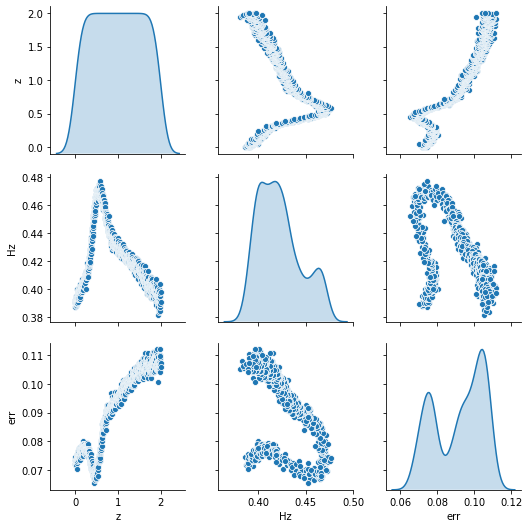

In [64]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")